# Export lion patches to training dataset

In [6]:
INPUT_DIR='../../input/kaggle-sea-lion/'
OUTPUT_DIR='../../output/kaggle-sea-lion/02/'

SHOW_IMAGES = True
FORCE_IMAGE = 0

IMAGE_DIMS = (148,148,3)

#%prun print('test')
#%pdb

In [7]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os

import modules.logging
from modules.logging import logger
import modules.lions as lions
from modules.utils import Timer
import modules.utils as utils

## Prepare output dataset

In [8]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

x_ds = None
y_ds = None

logger.info('creating dataset')
dataset_path = OUTPUT_DIR + utils.dataset_name('lion-patches', IMAGE_DIMS)
h5file = h5py.File(dataset_path, 'w')
x_ds = h5file.create_dataset('X', (0, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2]), maxshape=(None, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2]), chunks=(1, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2]), dtype='f')
y_ds = h5file.create_dataset('Y', (0, 5), maxshape=(None, 5), dtype='f')
logger.info('done')

2017-04-04 11:12:51,845 INFO Dir ../../output/kaggle-sea-lion/02/ created
2017-04-04 11:12:51,846 INFO creating dataset
2017-04-04 11:12:51,849 INFO done


## Process input photos and extract lions patches to dataset

### Open csv files

In [9]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]
logger.info('loading train.csv')
train = pd.read_csv(INPUT_DIR + "Train/train.csv")

2017-04-04 11:12:57,476 INFO loading train.csv


### Process each photo

2017-04-04 11:13:00,415 INFO process all photos from train file
2017-04-04 11:13:00,419 INFO > [started] processing photo ../../input/kaggle-sea-lion/Train/0.jpg...


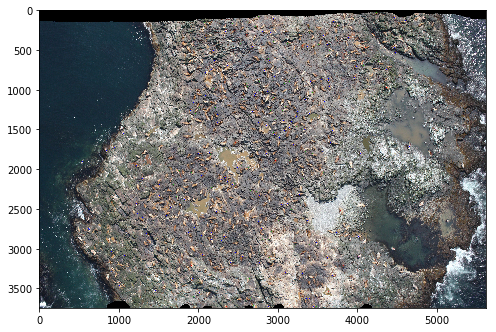

2017-04-04 11:13:04,388 INFO > [started] generating image patches. rows=44; cols=10...


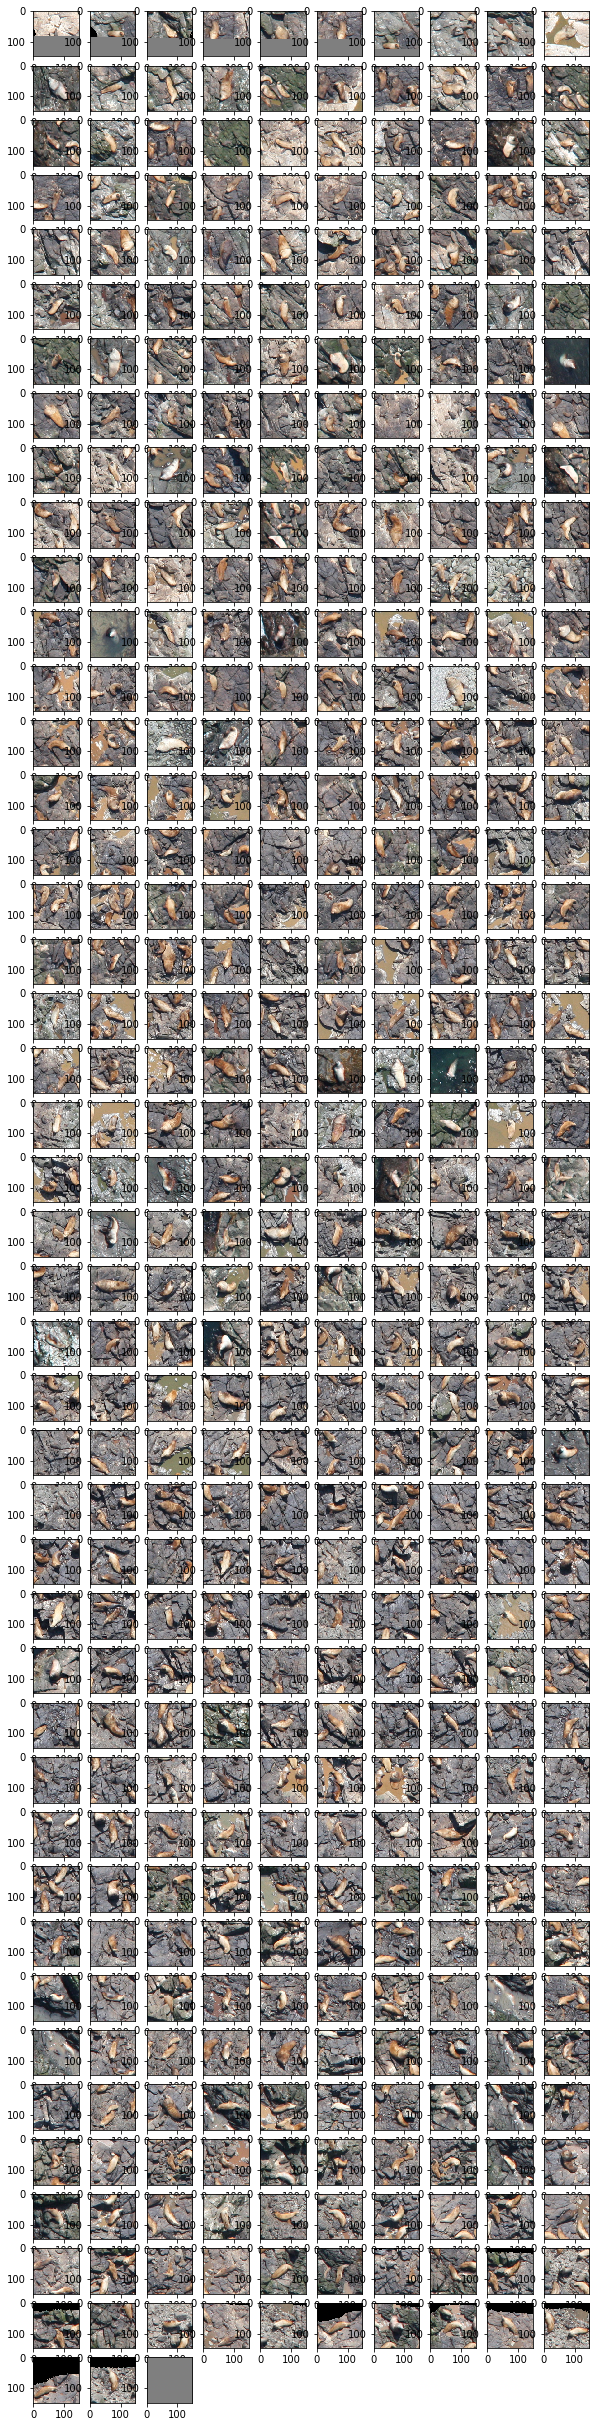

2017-04-04 11:13:49,015 INFO > [done]    generating image patches. rows=44; cols=10 (44626.800 ms)
2017-04-04 11:13:49,019 INFO total animals found: 945
2017-04-04 11:13:49,020 INFO total animals added to dataset: 433
2017-04-04 11:13:49,028 INFO detected classes count
2017-04-04 11:13:49,030 INFO [  62.   12.  485.   42.  344.]
2017-04-04 11:13:49,031 INFO -----
2017-04-04 11:13:49,032 INFO expected classes count
2017-04-04 11:13:49,033 INFO Pandas(Index=0, train_id=0, adult_males=62, subadult_males=12, adult_females=486, juveniles=42, pups=344)
2017-04-04 11:13:49,035 INFO -----
2017-04-04 11:13:49,036 INFO errors per class
2017-04-04 11:13:49,037 INFO [ 0.  0.  1.  0.  0.]
2017-04-04 11:13:49,039 INFO acum errors per class
2017-04-04 11:13:49,040 INFO [ 0.  0.  1.  0.  0.]
2017-04-04 11:13:49,041 INFO -----
2017-04-04 11:13:49,043 INFO acum detected classes count total
2017-04-04 11:13:49,044 INFO [  62.   12.  485.   42.  344.]
2017-04-04 11:13:49,045 INFO -----
2017-04-04 11:13:49

In [10]:
logger.info('process all photos from train file')
count = 0
total_errors = np.zeros(5)
total_classes = np.zeros(5)
total_classes_added = np.zeros(5)
for row in train.itertuples():
    #load images
    train_id = row[1]
    
    if(FORCE_IMAGE!=None and train_id!=FORCE_IMAGE):
        continue
    
    image_raw_file = INPUT_DIR + 'Train/'+ str(train_id) +'.jpg'
    image_dotted_file = INPUT_DIR + 'TrainDotted/'+ str(train_id) +'.jpg'

    if(train_id in MISMATCHED):
        logger.warning('skipping mismatched train_id ' + str(train_id))
        continue
    
    if(not os.path.isfile(image_raw_file)):
        logger.warning('file not found. skipping. file=' + image_raw_file)
        continue
        
    t = Timer('processing photo ' + image_raw_file)
    image_raw = cv2.imread(image_raw_file)
    image_dotted = cv2.imread(image_dotted_file)
    
    classes_count_total, classes_count_added = lions.export_lions(image_raw, image_dotted, x_ds, y_ds, IMAGE_DIMS, debug=SHOW_IMAGES, min_distance_others=40)
    logger.info('detected classes count')
    logger.info(str(classes_count_total))
    logger.info('-----')
    logger.info('expected classes count')
    logger.info(str(row))
    logger.info('-----')
    logger.info('errors per class')
    error = np.subtract(row[2:], classes_count_total)
    logger.info(str(error))
    logger.info('acum errors per class')
    total_errors = np.add(total_errors, np.absolute(error))
    logger.info(str(total_errors))
    logger.info('-----')
    logger.info('acum detected classes count total')
    total_classes = np.add(total_classes, classes_count_total)
    logger.info(str(total_classes))
    logger.info('-----')
    logger.info('acum detected classes count added to dataset')
    total_classes_added = np.add(total_classes_added, classes_count_added)
    logger.info(str(total_classes_added))
    t.stop()
    
    count = count + 1

logger.info('ERRORS PER CLASS')
logger.info(str(total_errors))
        
h5file.close()

### Validate dataset